In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview").sort_values("market_cap",ascending=False)
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["sma","sma_corr"],group_percentages=[0.5])
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label == "top" and portfolio.allocation_type.label == "equal":
            filtered_portfolios.append(portfolio)

In [8]:
# additional_portfolios = []
# for portfolio in portfolios:
#     if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label != "long_short":
#         for member in Indicator:
#             pm = copy.deepcopy(portfolio)
#             pm.ranking_metric = member.label
#             additional_portfolios.append(pm)

In [9]:
rolling_window = 20
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            # price = Indicator.OPTIMAL.calculate(price,timeframe=rolling_window)
            price = Indicator.SMA.calculate(price,timeframe=rolling_window)
            price = Indicator.SMACorr.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4266/4266 [03:05<00:00, 23.06it/s]


In [10]:
analysises = []
for portfolio in tqdm(filtered_portfolios):

        try:
            trades = portfolio.trades(simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = KPI.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            results["rolling_window"] = rolling_window
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.79s/it]


In [11]:
a = pd.DataFrame(analysises)

In [12]:
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [13]:
filtered_a = a.drop(["date","risk_type","position_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values("sharpe_ratio",ascending=False)
top = filtered_a.head(20).to_dict("records")[0]
filtered_a

,ranking_metric,grouping_type,selection_type,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window
0,sma,STANDARD_DEV,top,1.634079e+11,6.339320,2.577689e+10,1.211117,0.903105,0.531455,1.066800,6.339320,<financial_common.portfolio_management.portfol...,20
5,sma_corr,STANDARD_DEV,top,7.795146e+09,5.933195,1.313819e+09,1.198484,0.902202,0.532000,1.059824,5.933195,<financial_common.portfolio_management.portfol...,20
6,sma_corr,AVERAGE_RETURN,top,2.873236e+04,2.081606,1.380298e+04,1.131963,0.905573,0.509455,1.020908,2.081226,<financial_common.portfolio_management.portfol...,20
3,sma,SIMPLE_MOVING_AVERAGE,top,6.833806e+07,1.900890,3.595055e+07,1.209280,0.894680,0.492727,1.049692,1.900890,<financial_common.portfolio_management.portfol...,20
1,sma,AVERAGE_RETURN,top,6.976809e+05,1.887397,3.696524e+05,1.150486,0.905888,0.508727,1.030322,1.887383,<financial_common.portfolio_management.portfol...,20
4,sma,DRAWDOWN,top,2.321250e+06,1.749556,1.326765e+06,1.190545,0.890906,0.504182,1.041979,1.749552,<financial_common.portfolio_management.portfol...,20
8,sma_corr,SIMPLE_MOVING_AVERAGE,top,8.534887e+05,1.251893,6.817584e+05,1.190286,0.893281,0.493091,1.039731,1.251885,<financial_common.portfolio_management.portfol...,20
7,sma_corr,ROLLING_DOLLAR_VOLUME,top,1.443274e+04,1.157576,1.246808e+04,1.154984,0.903903,0.486727,1.026111,1.157155,<financial_common.portfolio_management.portfol...,20
9,sma_corr,DRAWDOWN,top,5.427879e+04,1.060110,5.120107e+04,1.173607,0.888661,0.504727,1.032481,1.060008,<financial_common.portfolio_management.portfol...,20
2,sma,ROLLING_DOLLAR_VOLUME,top,5.053683e+05,0.944818,5.348844e+05,1.171923,0.904226,0.487455,1.034716,0.944808,<financial_common.portfolio_management.portfol...,20


In [14]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

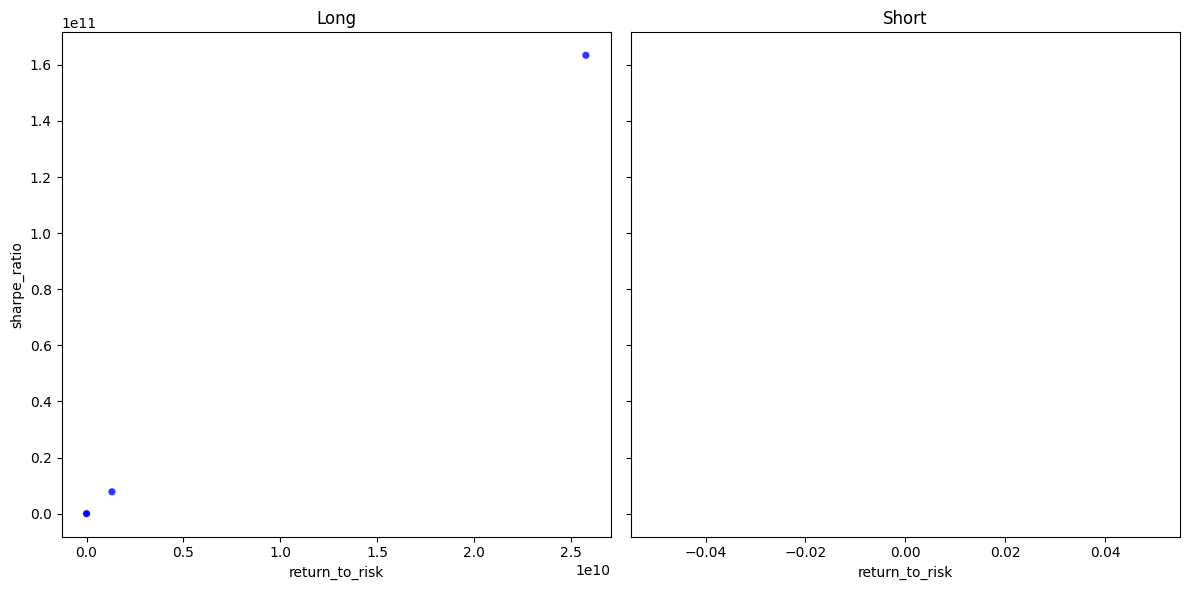

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [16]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

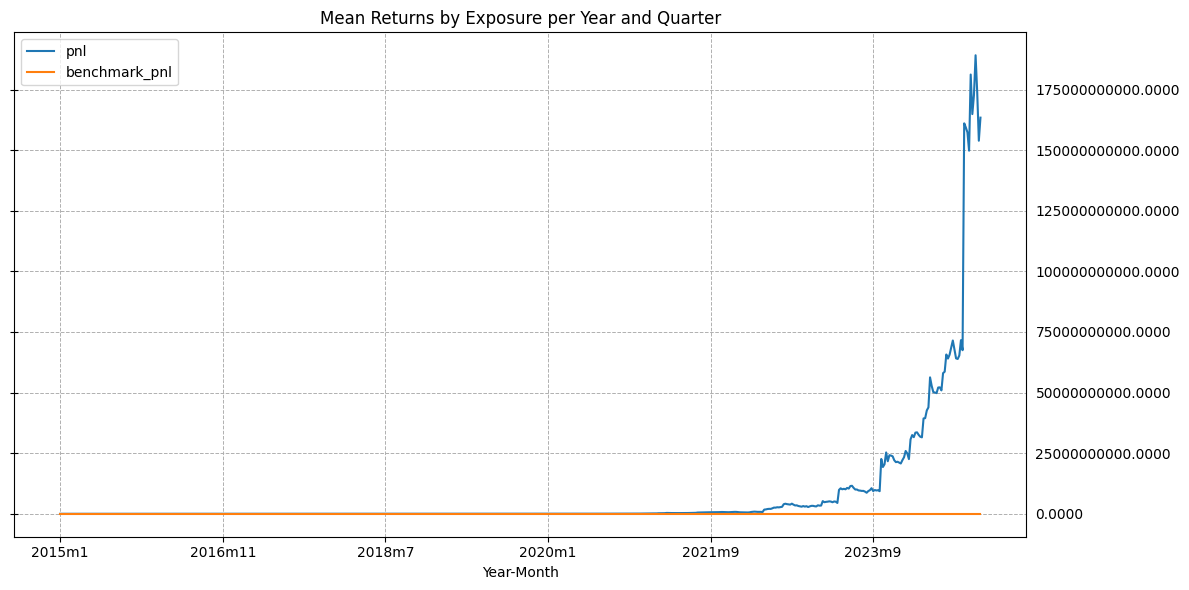

In [17]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
UAVS,5.992341
SNWV,4.621758
GMGI,3.726186
ADIL,2.459107
TRTX,2.306338
...,...
CVNA,0.768646
IHRT,0.756522
FMTO,0.730652


In [19]:
trades.sort_values("date",ascending=False).dropna().head(20)

,year,week,ticker,date,adjclose,sell_price,standard_dev,sma,risk,group_percentile,rank_percentile,position_type,weight,unweighted_return,winsorized_return,return,month,quarter
major_key,,,,,,,,,,,,,,,,,,
2024_51_0.9,2024,51,AQB,2024-12-20 00:00:00+00:00,0.5801,0.5240,0.126204,0.585490,0.198043,0.9,0.002,1.0,1,0.903293,0.903293,0.903293,12,4
2024_51_0.4,2024,51,ENTA,2024-12-20 00:00:00+00:00,6.3100,6.2800,1.003798,0.409784,0.166169,0.4,0.002,1.0,1,0.995246,0.995246,0.995246,12,4
2024_51_1.0,2024,51,FTFT,2024-12-20 00:00:00+00:00,0.2705,0.3014,0.054107,0.430426,0.135656,1.0,0.005,1.0,1,1.114233,1.114233,1.114233,12,4
2024_51_0.1,2024,51,CRVO,2024-12-20 00:00:00+00:00,1.9500,2.2300,3.368313,3.399079,0.267940,0.1,0.002,1.0,1,1.143590,1.143590,1.143590,12,4
2024_51_0.2,2024,51,APVO,2024-12-20 00:00:00+00:00,3.8800,4.4100,2.062966,1.307977,0.326647,0.2,0.002,1.0,1,1.136598,1.136598,1.136598,12,4
2024_51_0.3,2024,51,RLMD,2024-12-20 00:00:00+00:00,0.3888,0.3629,1.239146,4.246975,0.298785,0.3,0.002,1.0,1,0.933385,0.933385,0.933385,12,4
2024_51_0.0,2024,51,QTTB,2024-12-20 00:00:00+00:00,3.5000,3.5900,8.362040,5.258176,0.267292,0.0,0.005,1.0,1,1.025714,1.025714,1.025714,12,4
2024_51_0.5,2024,51,PBM,2024-12-20 00:00:00+00:00,1.8500,3.1800,0.729945,0.618784,0.951031,0.5,0.002,1.0,1,1.718919,1.718919,1.718919,12,4
2024_51_0.6,2024,51,CLRB,2024-12-20 00:00:00+00:00,0.2577,0.2350,0.477635,4.157538,0.211915,0.6,0.002,1.0,1,0.911913,0.911913,0.911913,12,4


In [22]:
portfolio.sort_values("return",ascending=False).head(20)

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week,Year-Month
505,2023-10-13 00:00:00+00:00,2.423955,2.261087e+10,143.820756,3.191120,2023,10,4,41,2023m10
52,2015-12-18 00:00:00+00:00,2.414356,2.618827e+02,49.915347,1.107531,2015,12,4,51,2015m12
556,2024-10-11 00:00:00+00:00,2.386861,1.610662e+11,221.142282,4.906744,2024,10,4,41,2024m10
272,2019-08-23 00:00:00+00:00,2.384811,3.683510e+06,90.532468,2.008750,2019,8,3,34,2019m8
433,2022-05-13 00:00:00+00:00,2.383373,1.726479e+09,110.387730,2.449303,2022,5,2,19,2022m5
33,2015-08-07 00:00:00+00:00,2.338683,2.626537e+01,52.365502,1.161895,2015,8,3,32,2015m8
185,2018-05-11 00:00:00+00:00,2.325759,4.906738e+04,93.871725,2.082842,2018,5,2,19,2018m5
479,2023-04-14 00:00:00+00:00,2.202978,9.852434e+09,132.910270,2.949037,2023,4,2,15,2023m4
15,2015-04-10 00:00:00+00:00,2.029667,8.765230e+00,47.174150,1.046708,2015,4,2,15,2015m4
84,2016-08-05 00:00:00+00:00,2.009878,1.016695e+03,52.536434,1.165688,2016,8,3,31,2016m8
